## Code and Writeup

team: FindMyPrice

authors: Yuyang Deng, Lingxiao Han, Aknazar Janibek, Xuanyi Wang

**Defining the Problem**

The decision-making process behind completing a purchase or signing up for a subscription is far more nuanced than it may initially appear. Understanding how visitors convert into subscribers or customers presents a significant challenge for businesses. The task of tracking and interpreting user interactions is inherently complex, given the multitude of variables influencing decision-making. While certain factors may clearly drive user behavior, the interplay of numerous contributing variables adds layers of complexity to analyzing and optimizing these decisions effectively.

The research question for our project is “Which factors are the most influential in determining user conversion rate?” We are interested in users—those who hear about the product from various sources, who use mobile devices or web to make purchases, those who make purchases on different operative systems, and those who live in different locations in the US—and their different attributes in relation to the pricing model.


**Data Collection**

The method for collecting the dataset was done by company ABC where they conducted a study, grouping the users into two groups. One group was offered a cheaper price of 39.0 while another group was offered a higher price of 59.0. The dataset also includes specific time, date, source used such as direct traffic or facebook advertisements, operative system such as mobile or web,  price offered, which group they were placed in, and whether they converted meaning if the user performed a desired action such as purchasing or signing up. 

The data collected for this pricing experiment contains two datasets. The user_table.csv contains 275,616 samples and has five features such as user_id, city, longitude, latitude, and country. The types of features we see range from string, integers, and floats. The test_results.csv contains a table of the experiment results performed on the users that participated. The table has 316,800 samples and contains eight features such as user_id, timestamp, source, device, operative_system, test, price, and conversion. The types of features are strings and integers. 

Some limitations and biases include the population size or sample size being limited to specifically users in the United States. The sample that was taken also might have bias since we are not sure if the sample conducted for the experiment was randomized. This suggests potential bias in user selection such as specific geographic areas in the United States or specific source used such as facebook ads, since we cannot say for certain that each user was randomly selected for this experiment. However, we are certain that 66% of the users were offered the cheaper price while 33% of the users were offered a higher price.


Import libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Import datasets:

In [3]:
raw_test_results = pd.read_csv("test_results.csv")
raw_user_table = pd.read_csv("user_table.csv")

**Data Preparation**

As mentioned in the data collection, the data collected was initially collected as two datasets. In order to consider geographical location as a potential factor for user conversion, we need to merge this feature into our results table. Using pandas method merge, we combine the two datasets by merging the tables on user_id, which is the primary key for our table. Successfully merging the tables into a unified dataset, we observe that the resulting table has 316,800 samples with twelve features. Merging the tables allows us to proceed with cleaning the dataset.

What does data cleaning mean?

When collecting the data, there are scenarios where not all the features are collected for every user due to unforeseen errors or circumstances. In this case, for the pricing experiment, geographical location was not obtained for all the users. This leads to values such as NaN, meaning not a number and is typically used when filling whitespace in the data. However, our goal for this study involves computation of the features in our dataset and having NaN values can lead to computational errors and inaccurate results. By using the dropna method, this allows us to drop any NaN or undefined values in the table to prevent computational errors. Having merged the tables and cleaned the data, we can proceed with exploring the data that we are dealing with in this study. While this does cut down our sample size, this in fact allows us to consider the geographical features such as city, longitude, and latitude to be considered in our study.

Merge two dataset on user_id, and drop all samples with missing values.

In [20]:
raw_data = pd.merge(raw_test_results, raw_user_table, on='user_id')
raw_data = raw_data.dropna()
raw_data.head(5)

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


Remove timestamp and country columns. For geographical location feature we decided to focus on city feature and thus removed latitude and longitude. Timestamps provide contextual information but for the focus of our study we want to look at factors directly to user engagement.

In [21]:
raw_data_modified = raw_data.drop(columns=["timestamp", "country", "test", 'user_id', 'lat', 'long'])
raw_data_modified.head(5)

,source,device,operative_system,price,converted,city
0,ads_facebook,mobile,iOS,39,0,Buffalo
1,seo-google,mobile,android,39,0,Lakeville
2,ads-bing,mobile,android,39,0,Parma
3,direct_traffic,mobile,iOS,59,0,Fayetteville
4,ads_facebook,web,mac,39,0,Fishers


**Model Building** 

To determine features that are influential to user conversion rate, we have done AB tastings on price, device, operative systems, source, and city respectively. In AB testing, we set our null hypothesis as these features have no influence on user conversion rate, and alternative hypotheses as these features have influence on user conversion rate. Since some features have more than two categories, in order to standardize the testing, we use total variance distance (TVD) as our test statistics. 
 
We applied for a permutation test. We first calculate the observed test statistic (TVD) based on the actual dataset. Next, we generate simulated test statistics by shuffling the feature values to break any relationship between the feature and conversion rates. We repeated this process 10000 times. For each permutation, we recalculated the TVD to build a distribution of test statistics under the null hypothesis. Finally, we compared the observed TVD to the simulated distribution to calculate a p-value. Tests on price, operating systems, and source rejected the null hypothesis, which indicates their influence on user conversion rates. Tests on device and city failed to reject the null hypothesis, suggesting no significant effect from these features.

Beyond AB testing, we also used sklearn's decision tree as a tool to build a model and verify our test results using machine learning. Our tree has a depth of three, and the output decision tree largely overlaps with the results from AB testing. Features that appear in the decision tree include operating system, price, and source, which are the three features that are statistically significant from our AB testing. The other two insignificant features, device and city, do not appear in our decision tree, further supporting our test outcomes.

In [8]:
def getTestStatistic(data, feature):
    # Calculate observed conversion rates by group
    grouped = data.groupby([feature])['converted'].mean()
    # Calculate the overall mean conversion rate (as baseline)
    overall_mean = data['converted'].mean()
    # Compute TVD
    tvd = 0.5 * sum(abs(grouped - overall_mean))
    return tvd

Next, we are going to simulate test statistics under null hypothesis by shuffling labels to see the influence of device on test statistics.

In [33]:
def get_shuffled_tbale(table, cata_var, num_var_list):
    """Generate a new table with shuffled catagorical variable"""
    shuffled_column = table[cata_var].sample(frac=1, replace=False).reset_index(drop=True)
    new_table = pd.DataFrame({cata_var: shuffled_column,})
    for num_var in num_var_list:
        new_table[num_var] = table[num_var]
    return new_table    

In [34]:
def do_test(feature, size):
    test_statistics_list = list()
    observed = getTestStatistic(raw_data, feature)  
    for i in range(size):
        test_statistics_list.append(float(getTestStatistic(get_shuffled_tbale(raw_data_modified, feature, ["converted"]), feature)))

    fig, ax = plt.subplots(1)
    sns.histplot(test_statistics_list, bins=60, color="red", label='Simulated Statistics')
    ax.axvline(x=observed, linestyle='-.', color='black', label='measured statsitic')
    ax.legend()
    ax.set_xlabel(f'Test Statistic Values')  
    ax.set_ylabel(f'Frequency')
    ax.set_title(f'Distribution of Simulated Statistics on {feature}') 

    plt.show()
    p_value1 = ((np.array(test_statistics_list) >= observed).sum() + 1) / (len(test_statistics_list) + 1)
    print(f'Estimated p-value: {p_value1:.50f}')

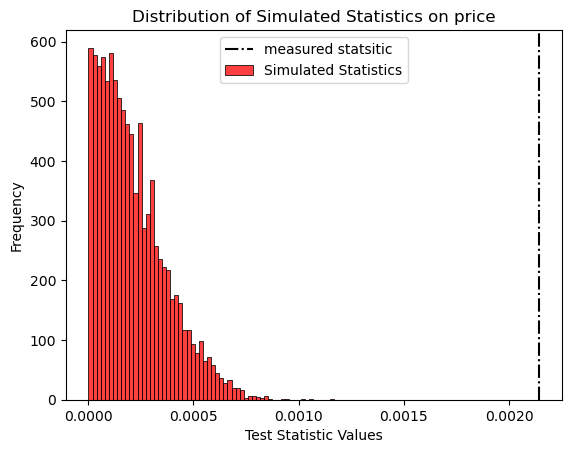

Estimated p-value: 0.00009999000099990001542895473596317401643318589777


In [35]:
do_test("price", 10000)

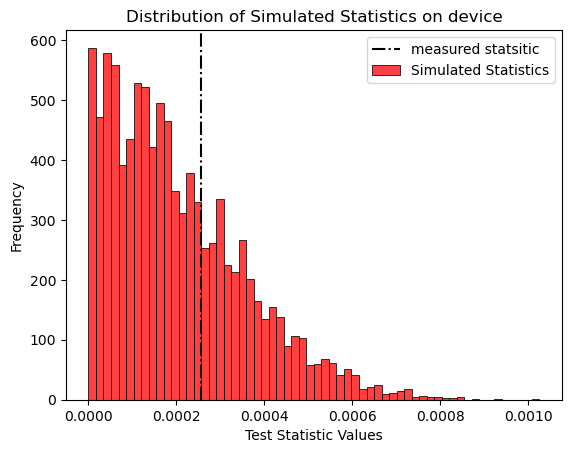

Estimated p-value: 0.32436756324367560511134911394037771970033645629883


In [36]:
do_test("device", 10000)

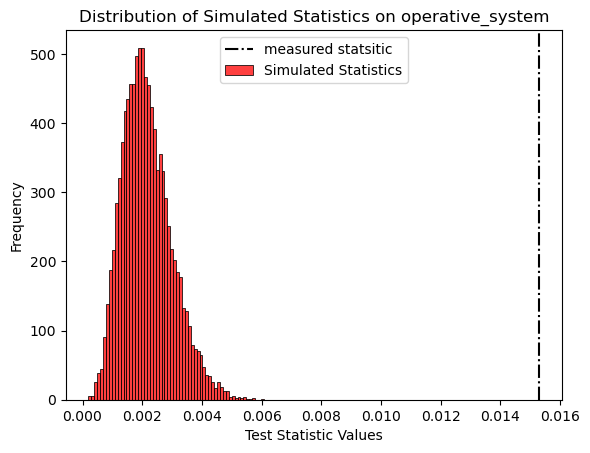

Estimated p-value: 0.00009999000099990001542895473596317401643318589777


In [37]:
do_test("operative_system", 10000)

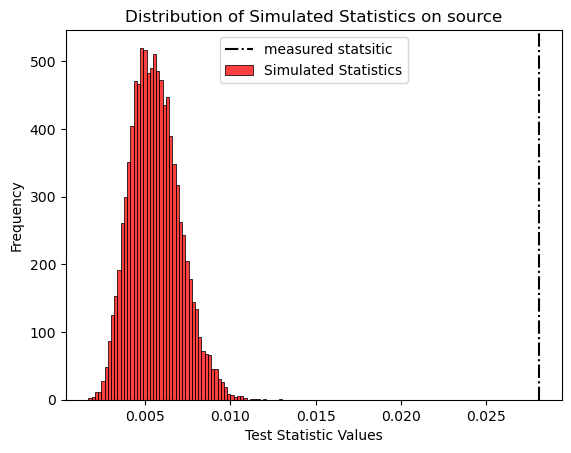

Estimated p-value: 0.00009999000099990001542895473596317401643318589777


In [38]:
do_test("source", 10000)

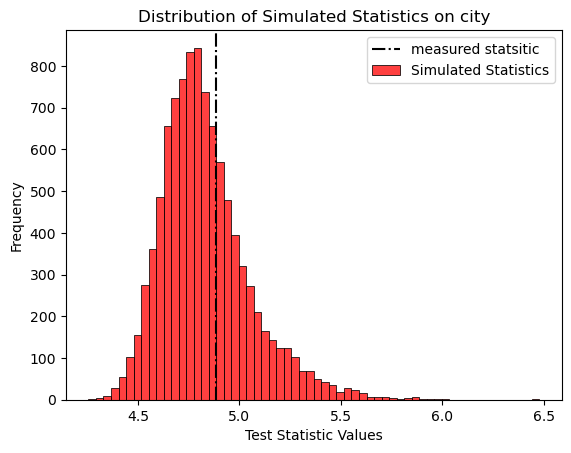

Estimated p-value: 0.33016698330166982522371199593180790543556213378906


In [39]:
do_test("city", 10000)

Prepare Data for Decision Tree

In [46]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
test_set = raw_data.drop(columns= ['user_id', 'timestamp', 'test', 'city', 'country', 'lat', 'long'] )

train = test_set.sample(frac=0.8)
test = test_set.drop(index=train.index)

train['source'] = train.source.replace({'ads_facebook': 0, 'seo-google': 1, 'ads-bing': 2, 'direct_traffic': 3, 'ads-google': 4, 'seo_facebook': 5, 'friend_referral': 6, 'ads_other': 7, 'ads-yahoo': 8, 'seo-yahoo': 9, 'seo-bing': 10, 'seo-other': 11})
train['device'] = train.device.replace({'mobile': 0, 'web': 1})
train['operative_system'] = train.operative_system.replace({'iOS': 0, 'android': 1, 'mac': 2, 'windows': 3, 'linux': 4, 'other': 5})

test['source'] = test.source.replace({'ads_facebook': 0, 'seo-google': 1, 'ads-bing': 2, 'direct_traffic': 3, 'ads-google': 4, 'seo_facebook': 5, 'friend_referral': 6, 'ads_other': 7, 'ads-yahoo': 8, 'seo-yahoo': 9, 'seo-bing': 10, 'seo-other': 11})
test['device'] = test.device.replace({'mobile': 0, 'web': 1})
test['operative_system'] = test.operative_system.replace({'iOS': 0, 'android': 1, 'mac': 2, 'windows': 3, 'linux': 4, 'other': 5})

train = train.astype(float)
test = test.astype(float)

C:\Users\aknazar\AppData\Local\Temp\ipykernel_2732\3062107546.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['source'] = train.source.replace({'ads_facebook': 0, 'seo-google': 1, 'ads-bing': 2, 'direct_traffic': 3, 'ads-google': 4, 'seo_facebook': 5, 'friend_referral': 6, 'ads_other': 7, 'ads-yahoo': 8, 'seo-yahoo': 9, 'seo-bing': 10, 'seo-other': 11})
C:\Users\aknazar\AppData\Local\Temp\ipykernel_2732\3062107546.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['device'] = train.device.replace({'mobile': 0, 'we

In [48]:
y_train = train['converted'] 
X_train = train.drop(columns=['converted']) 
print(X_train.shape, y_train.shape)

y_test = test['converted']
X_test = test.drop(columns=['converted']) 
print(X_test.shape, y_test.shape)

(220493, 4) (220493,)
(55123, 4) (55123,)


Score on train: 0.9816366052437039
Score on test: 0.9824029896776301


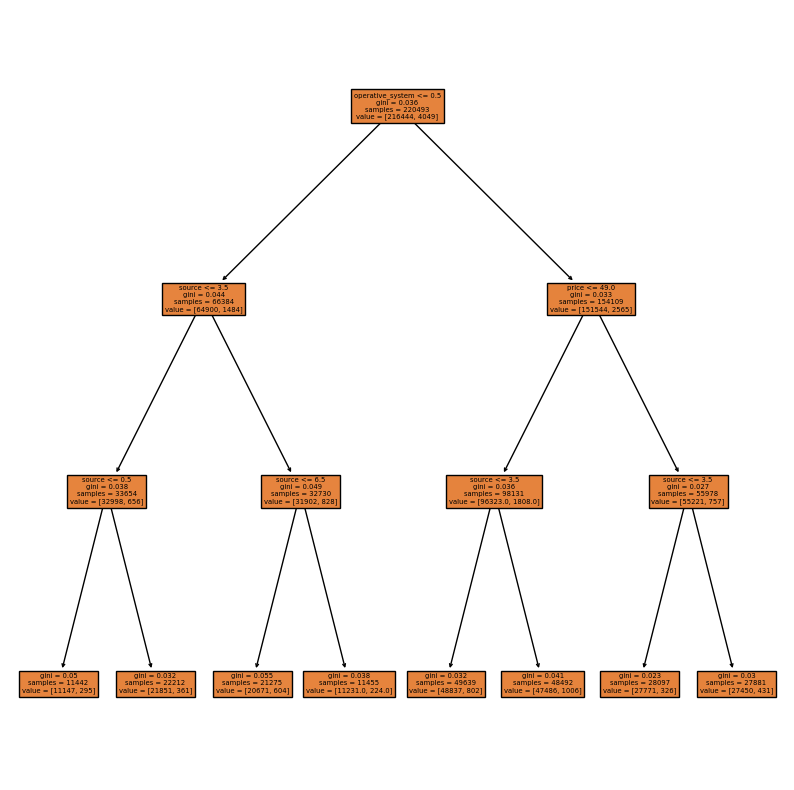

In [49]:
T = DecisionTreeClassifier(max_depth=3)
T.fit(X_train, y_train) # train the model

print('Score on train:', T.score(X_train, y_train)) # evaluate on train data
print('Score on test:', T.score(X_test, y_test)) # evaluate on test data

fig, ax = plt.subplots(1, figsize = (10, 10))
p = plot_tree(T, filled = True, feature_names = X_train.columns)

**Model Evaluation**